In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import cv2 as cv
import os
from PIL import Image



import torchvision.models as models
import torchvision
resnet = models.resnet18(pretrained=True)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# Any results you write to the current directory are saved as output.

In [52]:
device = torch.device('cuda:0')
root_dir = "./skin-cancer-mnist-ham10000"
print(torch.cuda.is_available())
print( torch.cuda.get_device_name())
resnet =  resnet.to(device)
torch.cuda.empty_cache()

True
GeForce GTX 950M


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 1.96 GiB total capacity; 1.28 GiB already allocated; 0 bytes free; 15.75 MiB cached)

In [53]:
skin_cancer_cells = pd.read_csv(root_dir + "/HAM10000_metadata.csv")
print(skin_cancer_cells)
all_ages = list(skin_cancer_cells.age)
is_valid = lambda x: not(np.isnan(x) or not x)
all_ages = list(filter(is_valid, all_ages))
avg = int(sum(all_ages)/len(all_ages))


         lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]


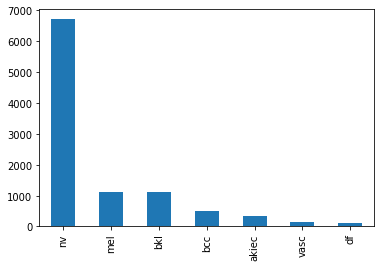

In [54]:
dx_dictionary = {
    "bcc": "basal cell carcinoma",
    "akiec":"Actinic keratoses and intraepithelial carcinoma / Bowen's disease",
    "bkl": "benign keratosis-like lesions",
    "df":"dermatofibroma",
    "mel":"melanoma",
    "nv":"melanocytic nevi",
    "vasc":"vascular lesions"
}

skin_cancer_cells["dx"].value_counts().plot(kind='bar')
weight = torch.cuda.FloatTensor([0.5, 0.3, 1, 0.1, 1, 7, 0.1])

In [55]:
skin_cancer_cells = skin_cancer_cells[["image_id", "dx"]]
print(len(skin_cancer_cells))

10015


In [69]:
#Initialize transformations for image augmentation

transforms_pytorch = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    torchvision.transforms.RandomVerticalFlip()
])

In [82]:
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, root_directory):
        self.df = dataframe
        self.dir = root_directory
        
    def get_index(self, label):
        labels = ["bcc","akiec","bkl","df","mel","nv","vasc"]
        return labels.index(label)
    
    def get_image(self, filename):
        directories = os.listdir(self.dir)
        directory = None
        for i in directories:
            if "." not in i and "{}.jpg".format(filename) in os.listdir("{}/{}".format(self.dir, i)):
                directory = i
        img = cv.cvtColor(cv.imread("{}/{}/{}.jpg".format(self.dir, directory, filename)), cv.COLOR_BGR2RGB)

        img = np.array(transforms_pytorch(Image.fromarray(img)))
        return self.normalize(img)
    
    def normalize(self, img):
        return cv.normalize(img, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image = self.df.iloc[index]
        return torch.FloatTensor(self.get_image(image['image_id'])).to(device), self.get_index(image['dx'])





In [83]:
dataset = SkinCancerDataset(skin_cancer_cells, root_dir)
batch_size = 16
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [84]:
class CancerNet(torch.nn.Module):
    
    
    def __init__(self):
        super(CancerNet, self).__init__()
        self.fc1 = torch.nn.Linear(1000, 400)
        self.fc2 = torch.nn.Linear(400, 140)
        self.act = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(140, 7)
        
    
    def forward(self, x):
        x = inception(x.cuda())
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        return x
    
class SuperCancerNet(torch.nn.Module):
    def __init__(self):
        super(SuperCancerNet, self).__init__()
        
        # First Convolutional
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()        
        
        self.conv1_1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
        self.conv1_2 = torch.nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3)
        self.norm1 = torch.nn.BatchNorm2d(6)
        
        self.drop1 = torch.nn.Dropout2d(0.4)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)
        
        # Second Convolutional
        self.conv2_1 = torch.nn.Conv2d(in_channels=6, out_channels=10, kernel_size=3, padding=1)
        self.conv2_2 = torch.nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=1)
        self.norm2 = torch.nn.BatchNorm2d(10)
        self.drop2 = torch.nn.Dropout2d(0.4)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)
        
        
    
        self.fc1 = torch.nn.Linear(in_features=10 * 11 * 11, out_features=256)
        self.fc2 = torch.nn.Linear(in_features=256, out_features=7)
        
    
    def forward(self, x):
        x = self.conv1_2(self.conv1_1(x))
        x = self.norm1(x)
        x = self.drop1(x)
        x = self.pool1(x)
        x = self.relu(x)
        
        x = self.conv2_2(self.conv2_1(x))
        x = self.norm2(x)
        x = self.drop2(x)
        x = self.pool2(x)
        x = self.relu(x)
        
        x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)

        return x

In [49]:
print(torch.cuda.memory_allocated())
net = CancerNet().to(device)

1378091008


In [86]:
criterion = torch.nn.CrossEntropyLoss(weight=weight)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
losses = []
accuracies = []

In [87]:
for j in range(100):
    torch.save(net, 'super_mytraining.pt')
    whole_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inp, labels = data
        optimizer.zero_grad()
        inp = inp.transpose(1, 3).transpose(2, 3)
        fws = net.forward(inp)
        loss = criterion(fws, labels.to(device))
        loss.backward()
        optimizer.step()
        whole_loss += loss.item()
    losses.append(whole_loss)
    print("Loss: ", whole_loss)
    total  = 0
    correct = 0
    for i, data in enumerate(validation_loader, 0):
        inp, labels = data
        inp = inp.transpose(1, 3).transpose(2, 3)
        outputs = net.forward(inp)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to(device) == labels.to(device)).sum().item()
    print("Accuracy: ", correct/(total))
    accuracies.append(correct/(total))
    torch.cuda.empty_cache()


KeyboardInterrupt: 

In [20]:
print(accuracies)

[]
